# Исследование эффективности "двойственного" алгоритма 
### Решение "двойственной" задачи к задаче минимизации максимального штрафа

## Код алгоритма

In [18]:
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.optimize import curve_fit

Класс для одного требования. **Расписание**, таким образом, -- список объектов класса `Task`

*Прим. к генерации значений* (см docstring класса `Task`):<br>
Как следует из теорем *1.1* и *1.4*, даже несмотря на наличие примеров с d<sub>j</sub> < r<sub>j</sub>, существует эквивалентный сгенерированному пример с d<sub>j</sub> > r<sub>j</sub>  

In [7]:
class Task:
    """
    A class for a single task.
    
    Init parameters:
        rMin, rMax -- recievement time limits
        pMin, pMax -- process time limits
        dMin, dMax -- due date limits
        
    For each task the recievement time, process time and due date
    are calculated randomly (uniform distribution) between given limits.
    Default limit values are in the code below.
    
    Additional parameters:
        phi -- the loss function for this particular task.
        By default returns its argument without changing it
    """
    r = 0
    p = 0
    d = 0
    phi = None
            
    def gen_r(self, rMin, rMax):
        self.r = int(random.uniform(rMin, rMax))
        
    def gen_p(self, pMin, pMax):
        self.p = int(random.uniform(pMin, pMax))
        
    def gen_d(self, dMin, dMax):
        self.d = int(random.uniform(dMin, dMax))
    
    def __init__(self, **kwargs):
        self.gen_r(kwargs.get('rMin', 1), kwargs.get('rMax', 100))
        self.gen_p(kwargs.get('pMin', 10), kwargs.get('pMax', 100))
        self.gen_d(kwargs.get('dMin', 1), kwargs.get('dMax', 200))
        self.phi = kwargs.get('phi', lambda x: x)
        
    def show(self):
        print("r =", self.r, "| p =", self.p, "| d =", self.d)
        
    @staticmethod
    def show_all(tasks):
        print(" r", "p", "d", sep=' | ', end='\n\n')
        for task in tasks:
            print(task.r, task.p, task.d, sep=' | ')
    
    @staticmethod
    def generate_multiple(nTasks):
        return list(Task() for i in range(nTasks))

Функция для расчета времени **окончания обслуживания** и **функция потерь**

In [8]:
def C(pi, j=None):
    """
    Returns the completion time of task number j in schedule pi
    """
    t = 0
    for task in pi[:j]:
        if t < task.r:
            t = task.r
        t += task.p
    return t

def phi(pi, j=None):
    """
    Returns the phi value of task number j in schedule pi.
    Uses the task`s own phi function
    """
    t = j or 0
    return pi[t].phi(C(pi, j))

Функция создания расписания $\pi$<sub>k</sub> -- переносит k-ый аргумент в конец расписания

In [9]:
def create_pi_k(pi, k):
    pi_k = pi.copy()
    pi_k.append(pi_k.pop(k))
    return pi_k

Сам "двойственный" алгоритм. Принимает список требований и возвращает оптимальное расписание

In [56]:
def create_optimal_pi(tasks):
    """
    Returns optimal schedule, the k value and max value of phi
    ToDo: maybe use map?
    """
    maxPhi = phi(tasks)
    maxK = -1
    
    sortedTasks = sorted(tasks, key=lambda x: x.r)
    for k, task in enumerate(sortedTasks):
        pi_k = create_pi_k(sortedTasks, k)
        phi_k = phi(pi_k)
        if phi_k > maxPhi:
            maxPhi = phi_k
            maxK = k
    return create_pi_k(sortedTasks, maxK), maxK, maxPhi

Алгоритм "брутфорса" -- для проверки **результатов работы** предложенного выше "двойственного" алгоритма. Выбирает оптимальное расписание из всех возможных (перебор за `О(n+1)!` операций).

Я не уверен, что правильно понял изначальную формулировку задачи поиска $\nu* = \max(\min(\phi()))$, поскольку данный алгоритм выдаёт иные значения, чем алгоритм 2.4 на странице 117.  

```python
def bruteforce(tasks):
    # initialize variables
    
    # local best schedule with minimum completion time
    localBest = tasks
    # best schedule in total
    best_pi = tasks
    # max loss value - nu* in the suggested algorithm
    maxPhi = phi(tasks)
    
    # loop for selecting max over all possible k`s
    for k in range(1, len(tasks)+1):
        # reinitialize minimum possible phi over all possible schedules
        minPhi = phi(tasks)
        
        # loop for selecting min over all possible schedules
        for pi_k in permutations(tasks):
            if phi(C(pi_k, -1)) < minPhi:
                minPhi = phi(C(pi_k, k))
                localBest = pi_k
                
        if minPhi > maxPhi:
            maxPhi = minPhi
            best_pi = localBest
    return best_pi, maxPhi
```

## Тестирование эффективности по времени

Класс для хранения информации о результатах тестирования **одного** расписания

In [11]:
class Timing:
    """
    Init parameters:
        nDims -- number of tasks in a schedule
        timings -- all timing results
        
    get_mean_time method calculates the mean value of all
    measured timings
    """
    nDims = 0
    timings = []
    
    def __init__(self, nDims, timings):
        self.nDims = nDims
        self.timings = timings
        
    def get_mean_time(self):
        return np.mean(self.timings)

**Параметры тестового набора**

In [12]:
minDim = 10
maxDim = 10010
step = 100

nExamples = 5

Генерация тестового набора

In [13]:
taskList = [Task.generate_multiple(n) for n in range(minDim, maxDim, step) for i in range(nExamples)]

Тестирование и запись объектов класса `Timing` в список `results`

In [14]:
results = []
for i, tasks in enumerate(taskList):
    print(i+1, "out of", len(taskList), "\r", end='')
    t = %timeit -q -o -r 3 create_optimal_pi(tasks)
    results.append(Timing(len(tasks), t.timings))

## Сериализация списка `results`

In [16]:
filename = 'pickle1.dmp'
p = pickle.dumps(results)

In [376]:
# Serializing
with open(filename, 'wb') as f:
    f.write(p)

In [17]:
# Deserializing
with open(filename, 'rb') as f:
    p = pickle.load(f)

## График и аппроксимация

Функция, которой будут аппроксимированы экспериментальные точки

In [19]:
def poly(x, A, b, p, c):
    return A * (x + b)**p + c

Аппроксимация

In [26]:
x = list(map(lambda x: x.nDims, p))
y = list(map(lambda x: x.get_mean_time(), p))
popt, pcov = curve_fit(poly, x, y, (1, 0, 2, 0))
perr = np.sqrt(np.diag(pcov))
print("Степень полинома: %.3f +- %.3f" % (popt[2], perr[2]))

Построение итогового графика

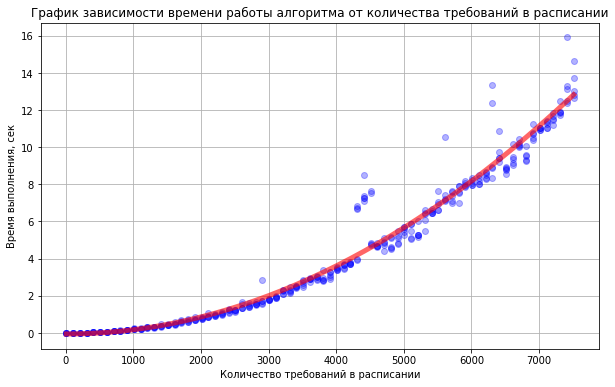

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid()
ax.plot(x, y, 'bo', alpha=0.3)
ax.set_title("График зависимости времени работы алгоритма от количества требований в расписании")
ax.set_xlabel("Количество требований в расписании")
ax.set_ylabel("Время выполнения, сек")
ax.plot(x, poly(x, *popt), color='r', linewidth=5, alpha=0.6)

## Выводы

- Случайным образом сгенерирован набор примеров размерностью от 10 до 7500 требований с шагом в 100 требований. Для каждой размерности из данного диапазона было сгенерировано по 5 примеров.
- Экспериментально доказана сложность "двойственного" алгоритма $O(n^2)$
- Проверку корректности работы алгоритма провести не удалось (см. примечание к функции *bruteforce*)
- В дальнейшем возможно улучшить данный эксперимент, используя многопроцессные вычисления и встроенные прекомпилированные функции python.